# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle
import random 

%matplotlib inline

In [3]:
df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [4]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [5]:
df.shape, df_content.shape

((45993, 3), (1056, 5))

In [6]:
df_content.sample().iloc[0,0][:200]

'* Developing IBM Streams Applications with Python (Version 1.6)\r\n * 1.0 Installing Python APIs\r\n * 2.0 Developing for the IBM Streaming Analytics service\r\n * 3.0 Developing with an IBM Streams install'

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45993 entries, 0 to 45992
Data columns (total 3 columns):
article_id    45993 non-null float64
title         45993 non-null object
email         45976 non-null object
dtypes: float64(1), object(2)
memory usage: 1.1+ MB


In [8]:
df_content.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056 entries, 0 to 1055
Data columns (total 5 columns):
doc_body           1042 non-null object
doc_description    1053 non-null object
doc_full_name      1056 non-null object
doc_status         1056 non-null object
article_id         1056 non-null int64
dtypes: int64(1), object(4)
memory usage: 41.3+ KB


In [9]:
print('Number of unique values for df')
for col in df.columns: 
    print(col, df[col].nunique())

Number of unique values for df
article_id 714
title 714
email 5148


In [10]:
print('Number of unique values for df_content')
for col in df_content.columns: 
    print(col, df_content[col].nunique())

Number of unique values for df_content
doc_body 1036
doc_description 1022
doc_full_name 1051
doc_status 1
article_id 1051


In [11]:
# Fill in the median and maximum number of user_article interactios below

median_val = df.groupby('email')['article_id'].count().sort_values(ascending=False).median() # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = df.groupby('email')['article_id'].count().sort_values(ascending=False).max() # The maximum number of user-article interactions by any 1 user is ______.

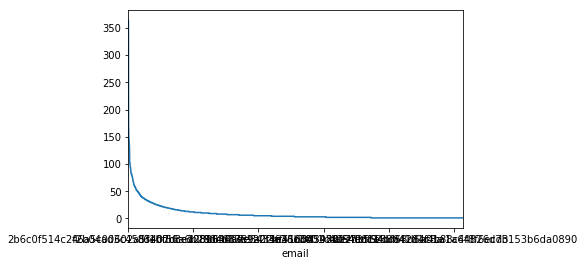

In [12]:
df.groupby('email')['article_id'].count().sort_values(ascending=False).plot();

In [13]:
df.groupby('email')['article_id'].count().sort_values(ascending=False).median()

3.0

In [14]:
df.groupby('email')['article_id'].count().sort_values(ascending=False).max()

364

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [15]:
# Find and explore duplicate articles
df_content.duplicated().sum()

0

In [16]:
#Shape of datafame, i.e. how many articles there are and how many columns
df_content.shape

(1056, 5)

In [17]:
# Remove any duplicated article_id from df_content
df_content.drop_duplicates(subset='article_id',keep='first',inplace=True)
df_content.shape


(1051, 5)

Only 5 duplicates were removed were removed

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [23]:
#Intersection between df_content.article_id and df.article_id
len(list(set(df_content.article_id).intersection(df.article_id)))

437

In [24]:
#Intersection between df_content.article_id and df.article_id

len(np.intersect1d(df_content.article_id,df.article_id))

437

In [25]:
# NUmber of unique values of article_id in df_content
df_content.article_id.nunique()

1051

In [26]:
# Number of unique emails
df.email.nunique()

5148

In [27]:

df.shape[0]

45993

In [28]:
df[:4]

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7


In [29]:
unique_articles = len(df.article_id.unique()) # The number of unique articles that have at least one interaction
total_articles = df_content.article_id.nunique() # The number of unique articles on the IBM platform
unique_users = df.email.nunique() # The number of unique users
user_article_interactions = df.shape[0] # The number of user-article interactions

In [30]:
user_article_interactions / unique_users

8.934149184149184

On average, users interact with 8.9341 articles

In [36]:
print(f'\
        number of unique articles: {unique_articles} \n\
        Total articles: {total_articles} \n\
        unique users: {unique_users} \n\
        Number of article-user interactions {user_article_interactions}')


        number of unique articles: 714 
        Total articles: 1051 
        unique users: 5148 
        Number of article-user interactions 45993


`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [37]:
df.groupby('article_id').count()['title'].sort_values(ascending=False).index[0]

1429.0

In [38]:
df[df.article_id == 1429.0]['title'][:1]

2    use deep learning for image classification
Name: title, dtype: object

In [39]:
df[df.article_id == 1429.0].shape[0]

937

In [40]:
most_viewed_article_id = '1429.0' # The most viewed article in the dataset as a string with one value following the decimal 
max_views = 937 # The most viewed article in the dataset was viewed how many times?

In [41]:
most_viewed_article_id, max_views

('1429.0', 937)

In [42]:
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,email,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7,1
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b,2
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074,3
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7,4
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2,5


In [43]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [44]:
df.sample()

,article_id,title,email,user_id
18430,1271.0,customer demographics and sales,157d0aba8d75f1c72e5428e4a64a51906008a43a,591


In [45]:
idx = df.groupby('article_id')['email'].count().sort_values(ascending=False).nlargest(2).index

In [46]:
idx.tolist()

[1429.0, 1330.0]

In [47]:
df[df.article_id.isin(idx)].drop_duplicates(subset='article_id')

,article_id,title,email,user_id
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074,3
66,1330.0,insights from new york car accident reports,20c6b6f18eb5fa53e5559afd74f4ccf01db37594,32


In [48]:
df.sample()

,article_id,title,email,user_id
9774,221.0,how smart catalogs can turn the big data flood...,95c7035ba31c7ab85d49262f01a6ee3f6d2dabed,72


In [49]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    
    top_articles_idx = df.groupby('article_id')['email'].count().sort_values(ascending=False).nlargest(n).index
    top_articles = df[df.article_id.isin(top_articles_idx)].drop_duplicates(subset='article_id')['title'].tolist()
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    top_articles = df.groupby('article_id')['email'].count().sort_values(ascending=False).nlargest(n).index.tolist()
    
 
    return top_articles # Return the top article ids

In [50]:
get_top_articles(2)

['use deep learning for image classification',
 'insights from new york car accident reports']

In [51]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['healthcare python streaming application demo', 'use deep learning for image classification', 'apache spark lab, part 1: basic concepts', 'predicting churn with the spss random tree algorithm', 'analyze energy consumption in buildings', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'gosales transactions for logistic regression model', 'insights from new york car accident reports', 'finding optimal locations of new store using decision optimization']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [52]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [53]:
users = df['email'].unique().tolist()

In [54]:
articles = df['article_id'].unique().tolist()

In [55]:
matrix = pd.DataFrame(index=users,columns = articles)

In [56]:
matrix.sample()

,1430.0,1314.0,1429.0,1338.0,1276.0,1432.0,593.0,1185.0,993.0,14.0,...,1135.0,881.0,183.0,655.0,1233.0,1156.0,555.0,708.0,575.0,972.0
9e09052aee67a42e040d3443cd7905b2a098822c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
df.sample()

,article_id,title,email,user_id
10900,1164.0,analyze open data sets with pandas dataframes,b2926913d95598ec0c007746d693fe3e466ff2d4,371


In [316]:
df.groupby(['user_id', 'article_id'])['article_id'].count()

user_id  article_id
1        43.0          1
         109.0         1
         151.0         1
         268.0         1
         310.0         2
         329.0         1
         346.0         1
         390.0         1
         494.0         1
         525.0         1
         585.0         2
         626.0         1
         668.0         2
         732.0         1
         768.0         1
         910.0         1
         968.0         1
         981.0         1
         1052.0        2
         1170.0        2
         1183.0        2
         1185.0        2
         1232.0        1
         1293.0        1
         1305.0        1
         1363.0        2
         1368.0        1
         1391.0        1
         1400.0        1
         1406.0        2
                      ..
5143     485.0         1
         495.0         1
         588.0         2
         1324.0        1
         1330.0        2
         1343.0        1
         1354.0        1
         1360.0        1
     

In [58]:
user_item_count = df.groupby(['user_id', 'article_id'])['article_id'].count().unstack()

In [318]:
df.groupby(['user_id', 'article_id'])['article_id'].count().unstack().head()

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [313]:
user_item_count.head()

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [59]:
user_item_count = user_item_count.fillna(0)

In [60]:
make_0  = lambda x: 1 if x >= 1 else 0

In [61]:
for col in user_item_count.columns:
    user_item_count[col] = user_item_count[col].apply(make_0)

In [62]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    user_item = df.groupby(['user_id', 'article_id'])['article_id'].count().unstack()
    #user_item = user_item.fillna(0)
    
    make_0  = lambda x: 1 if x >= 1 else 0
    
    for col in user_item.columns:
        user_item[col] = user_item[col].apply(make_0)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [63]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [64]:
user_item[:2]

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [65]:
user_item.T[:2]

user_id,1,2,3,4,5,6,7,8,9,10,...,5140,5141,5142,5143,5144,5145,5146,5147,5148,5149
article_id,,,,,,,,,,,,,,,,,,,,,
0.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2.0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [70]:
a = pd.DataFrame(np.array([[1,2],[3,4]]))
a

,0,1
0,1,2
1,3,4


In [67]:
b = pd.DataFrame(np.array([[11,12],[13,14]]))
b

,0,1
0,11,12
1,13,14


In [71]:
pd.DataFrame(np.dot(a,b))

,0,1
0,37,40
1,85,92


37 = 1* 11 + 2 * 13

40 = 1* 12 + 2* 14

85 = 3* 11 + 4* 13

92 = 3* 12 + 4* 14

In [73]:
user_dot_mat = np.dot(user_item, user_item.T)

In [75]:
user_dot_mat.shape

(5149, 5149)

In [104]:
index=range(1, 5150)
index

range(1, 5150)

In [107]:
sim_users = pd.DataFrame(user_dot_mat,index=index,columns=index)
sim_users.iloc[:5,:5]

,1,2,3,4,5
1,36,2,6,3,0
2,2,6,1,3,0
3,6,1,40,5,1
4,3,3,5,26,3
5,0,0,1,3,3


In [108]:
sim_users.loc[40,].sort_values(ascending=False)[:5]

40      52
4932    52
3782    33
23      32
49      25
Name: 40, dtype: int64

In [109]:
list(sim_users.loc[50,].sort_values(ascending=False)[1:][:5].index)

[50, 49, 3697, 3596, 52]

In [101]:
sim_users = pd.DataFrame(user_dot_mat, index=index, columns=index).loc[50].drop(50).sort_values(ascending=False)
sim_users

3478    5
3697    4
49      4
52      3
3596    3
2975    2
2982    2
207     2
844     2
638     2
3559    2
4526    2
4250    2
4145    2
3647    2
26      2
23      2
3651    2
4799    2
312     2
4453    2
5135    2
8       2
4       2
518     2
268     2
290     2
1057    1
3396    1
2847    1
       ..
3360    0
3361    0
3362    0
3363    0
3364    0
3366    0
3367    0
3368    0
3369    0
3370    0
3354    0
3352    0
3332    0
3351    0
3333    0
3334    0
3335    0
3336    0
3337    0
3339    0
3340    0
3341    0
3342    0
3344    0
3345    0
3347    0
3348    0
3349    0
3350    0
1       0
Name: 50, Length: 5148, dtype: int64

In [110]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    
    # Dot Product of user_item
    user_dot_mat = np.dot(user_item, user_item.T)
    
    #This will be used to have the same index and columns 
    shap = range(1,user_dot_mat.shape[0]+1)
    
    # Make the dot product matrix a DataFrame with same number of cols and rows
    # Then locate the values for a specific user
    # Then drop the user (as they will always have the highest dot product and is not technically a neighbor)
    # Order from largest to smallest
    
    sim_users = pd.DataFrame(user_dot_mat, index=shap, columns=shap)
    sim_users = sim_users.loc[user_id].drop(user_id).sort_values(ascending=False)
    
    #Covert to list
    most_similar_users = list(sim_users.index)
    
       
    return most_similar_users # return a list of the users in order from most to least similar
        

In [112]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 4201, 46, 3697]
The 5 most similar users to user 3933 are: [1, 3782, 23, 203, 4459]
The 3 most similar users to user 46 are: [4201, 3782, 23]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [119]:
random_articles = random.sample(list(df.article_id.values),15)
random_articles

[444.0,
 151.0,
 1170.0,
 1304.0,
 415.0,
 865.0,
 367.0,
 1305.0,
 268.0,
 1158.0,
 645.0,
 1320.0,
 1424.0,
 1163.0,
 844.0]

In [134]:
df[df.article_id.isin(random_articles)]['title'].unique()

array(['apache spark lab, part 1: basic concepts',
       'housing (2015): united states demographic measures',
       'gosales transactions for naive bayes model',
       'gosales transactions for logistic regression model',
       'use the cloudant-spark connector in python notebook',
       'analyze open data sets with spark & pixiedust',
       'jupyter notebook tutorial',
       'how to perform a logistic regression in r',
       'analyze traffic data from the city of san francisco',
       'declarative machine learning', 'sector correlations shiny app',
       'using machine learning to predict value of homes on airbnb',
       'use spark for python to load data and run sql queries',
       'airbnb data for analytics: washington d.c. reviews',
       'visualising data the node.js way'], dtype=object)

In [155]:
ordered_df = df[df.article_id.isin(random_articles)][['article_id','title']].drop_duplicates().set_index('article_id').loc[random_articles]
ordered_df

,title
article_id,
444.0,declarative machine learning
151.0,jupyter notebook tutorial
1170.0,"apache spark lab, part 1: basic concepts"
1304.0,gosales transactions for logistic regression m...
415.0,using machine learning to predict value of hom...
865.0,analyze traffic data from the city of san fran...
367.0,visualising data the node.js way
1305.0,gosales transactions for naive bayes model
268.0,sector correlations shiny app


In [ ]:
df.loc

In [156]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Your code here
    # I do this to have articles in the same order as the article_ids 
    ordered_df = df[df.article_id.isin(article_ids)][['article_id','title']].drop_duplicates().set_index('article_id').loc[article_ids]
    article_names = list(ordered_df.title.values)
    
    
    #article_names = list(df[df.article_id.isin(article_ids)]['title'].unique())
   
    
    return article_names # Return the article names associated with list of article ids

In [157]:
get_article_names([1314,1430,1429,1338])

['healthcare python streaming application demo',
 'using pixiedust for fast, flexible, and easier data analysis and experimentation',
 'use deep learning for image classification',
 'ml optimization using cognitive assistant']

In [113]:
df.head()

The history saving thread hit an unexpected error (OperationalError('disk I/O error',)).History will not be written to the database.


,article_id,title,email,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7,1
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b,2
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074,3
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7,4
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2,5


#### Get user articles

In [158]:
user_item[:4]

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [164]:
random_users = random.sample(list(user_item.index),15)
random_users

[797,
 3193,
 2017,
 1577,
 3979,
 1218,
 2580,
 2915,
 774,
 682,
 247,
 2891,
 4767,
 3015,
 2944]

In [211]:
get_article_names(user_item.loc[random_users[0]][user_item.loc[random_users[0]] >0].index.tolist())

['apple, ibm add machine learning to partnership with watson-core ml coupling',
 'rapidly build machine learning flows with dsx',
 'ml algorithm != learning machine',
 'analyze accident reports on amazon emr spark',
 'healthcare python streaming application demo',
 'learn basics about notebooks and apache spark',
 'model bike sharing data with spss',
 'movie recommender system with spark machine learning',
 'the nurse assignment problem',
 'total population by country',
 'visualize data with the matplotlib library']

In [241]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    article_ids = [int(float(i)) for i in article_ids]
    # the greyed out code can be useful if the order of the article_ids is important     
    ordered_df = df[df.article_id.isin(article_ids)][['article_id','title']].drop_duplicates().set_index('article_id').loc[article_ids]
    article_names = list(ordered_df.title.values)
    
    #article_names = list(df[df.article_id.isin(article_ids)]['title'].unique())
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Your code here
    
    article_ids = user_item.loc[user_id][user_item.loc[user_id] >0].index.tolist()
    article_ids = [str(float(i)) for i in article_ids]
    article_names = get_article_names(article_ids)
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # Your code here
    
    recs = []
    counter = 0
    sim_users = find_similar_users(user_id)
    for neighbor in sim_users: 
        if len(recs) < m:
            neigh_art_ids, neigh_art_names = get_user_articles(neighbor)
            new_arts = np.setdiff1d(neigh_art_ids, art_id_0,assume_unique=True)

            for art in new_arts:
                    if art not in recs:
                        recs.append(art)
        else: 
            break
    recs = recs[:m]
    #recs = get_article_names(recs)
    
    return recs # return your recommendations for this user_id    

In [204]:
user_user_recs(random_users[0])

['working interactively with rstudio and notebooks in dsx',
 'this week in data science (april 18, 2017)',
 'timeseries data analysis of iot events by using jupyter notebook',
 'got zip code data? prep it for analytics. – ibm watson data lab – medium',
 'higher-order logistic regression for large datasets',
 'using machine learning to predict parking difficulty',
 'deep forest: towards an alternative to deep neural networks',
 'experience iot with coursera',
 'using brunel in ipython/jupyter notebooks',
 'deep learning with tensorflow course by big data university']

In [207]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['deep learning with tensorflow course by big data university',
 'tensorflow quick tips',
 'sector correlations shiny app',
 'time series prediction using recurrent neural networks (lstms)',
 'introduction to market basket analysis in\xa0python',
 'fighting gerrymandering: using data science to draw fairer congressional districts',
 'introducing ibm watson studio ',
 'python for loops explained (python for data science basics #5)',
 'new shiny cheat sheet and video tutorial',
 'tidyverse practice: mapping large european cities']

In [214]:
df[df.article_id == 1024.0][:1]

,article_id,title,email,user_id
2734,1024.0,using deep learning to reconstruct high-resolu...,11852f6327839440b11c155fdb27defbbfa79786,708


In [235]:
get_article_names([1024.0])

['using deep learning to reconstruct high-resolution audio']

In [243]:
get_user_articles(20)

(['232.0', '844.0', '1320.0'],
 ['self-service data preparation with ibm data refinery',
  'use the cloudant-spark connector in python notebook',
  'housing (2015): united states demographic measures'])

In [244]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [245]:
df.head()

,article_id,title,email,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7,1
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b,2
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074,3
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7,4
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2,5


In [252]:
user_item.iloc[:5,:5]

article_id,0.0,2.0,4.0,8.0,9.0
user_id,,,,,
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0
5,0,0,0,0,0


In [254]:
neighbors_df = pd.DataFrame(columns=['neighbor_id','similarity','num_interactions'])
neighbors_df

,neighbor_id,similarity,num_interactions


In [255]:
random_users[0]

797

In [257]:
def find_similar_users_dist(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    
    # Dot Product of user_item
    user_dot_mat = np.dot(user_item, user_item.T)
    
    #This will be used to have the same index and columns 
    shap = range(1,user_dot_mat.shape[0]+1)
    
    # Make the dot product matrix a DataFrame with same number of cols and rows
    # Then locate the values for a specific user
    # Then drop the user (as they will always have the highest dot product and is not technically a neighbor)
    # Order from largest to smallest
    
    sim_users = pd.DataFrame(user_dot_mat, index=shap, columns=shap)
    sim_users = sim_users.loc[user_id].drop(user_id).sort_values(ascending=False)
    
    #Covert to list
    most_similar_users = list(sim_users.index)
    most_similar_users_dist = list(sim_users.values)
    
       
    return most_similar_users, most_similar_users_dist # return a list of the users in order from most to least similar

In [258]:
most_similar_users_0, most_similar_users_dist_0 = find_similar_users_dist(random_users[0])
most_similar_users_0[:5], most_similar_users_dist_0[:5]

([3724, 23, 3782, 3621, 242], [11, 8, 8, 7, 7])

In [259]:
neighbors_df['neighbor_id'] = most_similar_users_0
neighbors_df['similarity'] = most_similar_users_dist_0
neighbors_df.head()

,neighbor_id,similarity,num_interactions
0,3724,11,NaN
1,23,8,NaN
2,3782,8,NaN
3,3621,7,NaN
4,242,7,NaN


In [266]:
neighbors_df.neighbor_id.tolist()[:4]

[3724, 23, 3782, 3621]

In [276]:
neighbors_df['num_interactions'] = user_item.loc[neighbors_df.neighbor_id.tolist()].sum(axis=1).tolist()
neighbors_df.sort_values(by=['similarity','num_interactions'],ascending=False)[:5]

,neighbor_id,similarity,num_interactions
0,3724,11,12
1,23,8,135
2,3782,8,135
14,49,7,101
7,3697,7,100


In [278]:
get_top_sorted_users(random_users[0])

,neighbor_id,similarity,num_interactions
0,3724,11,12
1,23,8,135
2,3782,8,135
3,3621,7,45
4,242,7,59
5,3540,7,72
6,3596,7,59
7,3697,7,100
8,912,7,71
9,3910,7,60


In [295]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Your code here
    neighbors_df = pd.DataFrame(columns=['neighbor_id','similarity','num_interactions'])
    neighbors_df.neighbor_id, neighbors_df.similarity = find_similar_users_dist(user_id)
    neighbors_df['num_interactions'] = user_item.loc[neighbors_df.neighbor_id.tolist()].sum(axis=1).tolist()
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # Your code here
    
    recs = []
    counter = 0
    sim_users = get_top_sorted_users(user_id).neighbor_id.tolist()
    for neighbor in sim_users: 
        if len(recs) < m:
            neigh_art_ids, neigh_art_names = get_user_articles(neighbor)
            new_arts = np.setdiff1d(neigh_art_ids, art_id_0,assume_unique=True)

            for art in new_arts:
                    if art not in recs:
                        recs.append(art)
        else: 
            break
            
    recs = recs[:m]
    rec_names = get_article_names(recs)
    
    return recs, rec_names

In [296]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['43.0', '109.0', '111.0', '112.0', '164.0', '213.0', '225.0', '232.0', '313.0', '337.0']

The top 10 recommendations for user 20 are the following article names:
['deep learning with tensorflow course by big data university', 'tensorflow quick tips', 'tidy up your jupyter notebooks with scripts', 'building custom machine learning algorithms with apache systemml', 'learn tensorflow and deep learning together and now!', 'modeling energy usage in new york city', 'a visual explanation of the back propagation algorithm for neural networks', 'self-service data preparation with ibm data refinery', 'what is machine learning?', 'generalization in deep learning']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [279]:
get_top_sorted_users(1)

,neighbor_id,similarity,num_interactions
0,3933,35,35
1,23,17,135
2,3782,17,135
3,203,15,96
4,4459,15,96
5,3870,14,75
6,131,14,75
7,4201,13,40
8,46,13,40
9,3697,12,100


In [280]:
get_top_sorted_users(131)

,neighbor_id,similarity,num_interactions
0,3870,74,75
1,3782,39,135
2,23,38,135
3,203,33,96
4,4459,33,96
5,49,29,101
6,98,29,97
7,3697,29,100
8,3764,29,97
9,242,25,59


In [281]:
### Tests with a dictionary of results

user1_most_sim = 3933# Find the user that is most similar to user 1 
user131_10th_sim = 242# Find the 10th most similar user to user 131

In [282]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Provide your response here.**

The best way would be to assume nothing about them and give them the 10 most interacted with articles
get_top_articles() is the best function for this

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [287]:
get_top_article_ids(10)

[1429.0,
 1330.0,
 1431.0,
 1427.0,
 1364.0,
 1314.0,
 1293.0,
 1170.0,
 1162.0,
 1304.0]

In [290]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = [str(i) for i in get_top_article_ids(10)]


In [291]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [298]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [299]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [300]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix)

In [305]:
u[:4]

array([[-4.30899801e-02,  8.30671762e-03,  2.75704572e-02, ...,
         8.82759925e-06,  2.14304725e-04, -5.94105009e-03],
       [-1.03765691e-02,  1.64771768e-02,  6.04781444e-03, ...,
         1.39723600e-03,  7.71483830e-04, -9.24381471e-04],
       [-4.98474594e-02,  1.44789670e-03, -1.64960631e-02, ...,
         2.67129324e-03,  7.04379917e-04,  2.46254254e-03],
       [-4.25553357e-02,  3.94068256e-02, -3.67445597e-02, ...,
         9.50142330e-04, -6.41465378e-03, -1.48530970e-03]])

In [304]:
s[:4]

array([55.34570373, 23.2486418 , 21.76002282, 20.65833406])

In [306]:
vt[:4]

array([[-0.00221822, -0.00113697, -0.0082582 , ..., -0.00789215,
        -0.02783982, -0.00034968],
       [ 0.00207737,  0.00038664,  0.00151981, ..., -0.01561209,
         0.00097083, -0.00043003],
       [-0.00043211,  0.00246677,  0.00428289, ...,  0.01206136,
         0.01218322,  0.00108416],
       [-0.00332539, -0.00520446,  0.00287235, ...,  0.0022295 ,
         0.04325963,  0.00049889]])

In [307]:
s.shape, u.shape, vt.shape

((714,), (5149, 5149), (714, 714))

**Provide your response here.**

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

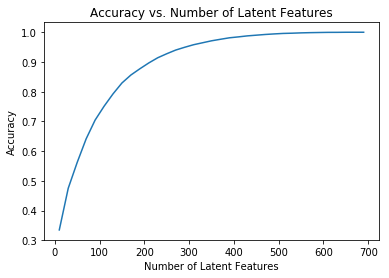

In [308]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [309]:
df.sample()

,article_id,title,email,user_id
11112,1436.0,welcome to pixiedust,276d9d8ca0bf52c780b5a3fc554fa69e74f934a3,131


In [310]:
df_train = df.head(40000)
df_test = df.tail(5993)

In [325]:
user_item_train = create_user_item_matrix(df_train)
user_item_test = create_user_item_matrix(df_test)

user_item_test.head()

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1432.0,1433.0,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1443.0
user_id,,,,,,,,,,,,,,,,,,,,,
2917,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3024,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3093,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3193,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3527,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [322]:
test_idx = user_item_test.index.values
test_idx[:4]

array([2917, 3024, 3093, 3193], dtype=int64)

In [323]:
test_arts = user_item_test.columns.values
test_arts[:4]

array([0., 2., 4., 8.])

In [326]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Your code here
    
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    
    test_idx = user_item_test.index.values
    test_arts = user_item_test.columns.values
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [331]:
df_test.head(2)

,article_id,title,email,user_id
40000,1053.0,access mysql with python,2dbe7ff11dd953a41eba82f8e0d8e5c4cb2abdf2,4487
40001,1314.0,healthcare python streaming application demo,2dbe7ff11dd953a41eba82f8e0d8e5c4cb2abdf2,4487


In [337]:
# How many users can we make predictions for in the test set?
len(np.intersect1d(df_train.user_id.unique(), df_test.user_id.unique()))

20

In [338]:
# How many users in the test set are we not able to make predictions for because of the cold start problem?
## Total articles in test - previous answer

len(df_test.user_id.unique()) - len(np.intersect1d(df_train.user_id.unique(), df_test.user_id.unique()))

662

In [333]:
# How many articles can we make predictions for in the test set?
## With this we can tell how many are in both training and data set
## This gives enough information to on the matrix and find similarities
len(np.intersect1d(df_train.article_id.unique(), df_test.article_id.unique()))

574

In [336]:
# How many articles in the test set are we not able to make predictions for because of the cold start problem?
## Total articles in test - previous answer

len(df_test.article_id.unique()) - len(np.intersect1d(df_train.article_id.unique(), df_test.article_id.unique()))

0

In [342]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many movies can we make predictions for in the test set?': b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [344]:
user_item_train[:5]

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [345]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)# fit svd similar to above then use the cells below

In [ ]:
# Use these cells to see how well you can use the trainingu 
# decomposition to predict on test data

In [353]:
train_idx = user_item_train.index.values
train_idx #Train user ids

array([   1,    2,    3, ..., 4485, 4486, 4487], dtype=int64)

In [357]:
train_arts = user_item_train.columns.values
train_arts[:5] #train articles

array([0., 2., 4., 8., 9.])

In [358]:
subset_test_user  = np.intersect1d(train_idx, test_idx)
subset_test_user

array([2917, 3024, 3093, 3193, 3527, 3532, 3684, 3740, 3777, 3801, 3968,
       3989, 3990, 3998, 4002, 4204, 4231, 4274, 4293, 4487], dtype=int64)

In [360]:
subset_test_art = np.intersect1d(train_arts, test_arts)
subset_test_art[:5]

array([0., 2., 4., 8., 9.])

In [362]:
train_indexes = np.where(np.in1d(train_idx, subset_test_user))[0]
train_articles = np.where(np.in1d(train_arts, subset_test_art))[0]

In [364]:
test_indexes = np.where(np.in1d(test_idx, subset_test_user))[0]
test_indexes

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19], dtype=int64)

In [369]:
user_item_test_subset = user_item_test.iloc[test_indexes,:]
user_item_test_subset.shape

(20, 574)

In [370]:
user_item_train_subset = user_item_train.iloc[train_indexes,train_articles]
user_item_train_subset.shape

(20, 574)

In [376]:
user_item_train_subset == user_item_test_subset

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1432.0,1433.0,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1443.0
user_id,,,,,,,,,,,,,,,,,,,,,
2917,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
3024,True,True,True,True,True,False,True,True,True,True,...,True,True,True,True,False,True,True,True,True,True
3093,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,False,True,True,True,True,True
3193,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
3527,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
3532,True,True,True,False,True,False,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
3684,True,True,True,True,True,True,True,True,True,True,...,True,False,True,True,True,True,True,True,True,True
3740,True,True,True,True,True,False,True,True,False,True,...,True,True,True,True,True,True,True,True,True,True
3777,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True


In [378]:
np.arange(10,574,10)

array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260,
       270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390,
       400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520,
       530, 540, 550, 560, 570])

In [379]:
np.arange?

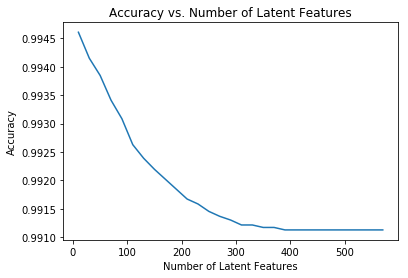

In [385]:
## Code from above

num_latent_feats = np.arange(10,574,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_train_k, u_train_k, vt_train_k = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    s_test_k, u_test_k, vt_test_k = s_train_k, u_train_k[train_indexes,:], vt_train_k[:,train_articles]
    
    # take dot product
    user_item_est_subset = np.around(np.dot(np.dot(u_test_k, s_test_k), vt_test_k))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_test_subset, user_item_est_subset)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

Warning: there are only 20 users which are shared between testing and training, which warrants caution (low number makes it difficult to assess significance of results)

Recommendations:
Qualitative: Although in this context we look mostly at sophisticated analytics to determine efficacy, a simple interview / user experience session can provide highly relevant qualitative feedback

Quantitative: 
Te best way to test if this change is significant is by using an *experiment* i.e. A/B Testing
this can be helpful since you are able to track if the recommendation engine is leading to action, i.e. more articles read. 

Some metrics that can be interesting to assess in this context: article views, total time spent on site, satisfaction based on survey

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])